# Dependencies

In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import matplotlib

#plt.rc('text', usetex=True)
plt.rc('font', family='serif')

<br>

# Functions

In [2]:
def dataset_preproc():
    
    data_description = pd.read_csv("./cols_data_specs.csv")
    data_col_fixed   = ['label']; data_col_fixed.extend(data_description.sort_values("specification").iloc[:,1])
    data = pd.read_csv("./data.csv", index_col=0)
    data = data[sorted(data.columns)]
    data.columns = data_col_fixed
    data = data[["label"]+list(data_description[data_description.type_var == "headline"].variable.values)]
    data.loc[data.label == 0,["label"]] = 1
    data.to_csv("./dataset.csv")
    
    return(data, data_description, dict(zip(list(data_description.variable),list(data_description.description))))

In [3]:
def ADASYN_res(X,y):
    
    sm = ADASYN(sampling_strategy="all", n_neighbors=3)
    X_train_res, y_train_res = sm.fit_sample(X, y)
    
    return(X_train_res, y_train_res)

In [4]:
def average_accuracies(X,y,depth_max, times_max, thresh=False):
    
    df = pd.DataFrame({"Depth": range(1,depth_max+1)})
    df_train = pd.DataFrame({"Depth": range(1,depth_max+1)})
    for time in range(1,1+times_max):
        cv = StratifiedKFold(n_splits=5, shuffle=True)
        accuracies = list()
        accuracies_train = list()
        for depth in range(1,depth_max+1):
            fold_accuracy = []
            fold_accuracy_train = []
            for (train, test), i in zip(cv.split(X, y), range(5)):
                X_train_res, y_train_res = ADASYN_res(X.iloc[train],y.iloc[train])
                X_train_res, X_test = pd.DataFrame(X_train_res, columns=X.columns), pd.DataFrame(X.iloc[test], columns=X.columns)
                if thresh == True:
                    X_train_res = thresh_maker(X_train_res)
                    X_test = thresh_maker(X_test)
                y_pred = RandomForestClassifier(max_depth = depth, n_estimators=100).\
                                                fit(X_train_res, y_train_res).predict(X_test)
                fold_accuracy.append(accuracy_score(y.iloc[test], y_pred))
                y_pred_train = RandomForestClassifier(max_depth = depth, 
                                                                           n_estimators=100).\
                                                    fit(X_train_res, y_train_res).predict(X_train_res)
                fold_accuracy_train.append(accuracy_score(y_train_res,y_pred_train))
            
            avg = sum(fold_accuracy)/len(fold_accuracy)
            avg_train = sum(fold_accuracy_train)/len(fold_accuracy_train)
            accuracies.append(avg)
            accuracies_train.append(avg_train)
        df["Run %s" % time] = accuracies
        df_train["Run %s" % time] = accuracies_train
        
    df = df.set_index("Depth")
    df_train = df_train.set_index("Depth")
    df["Average Accuracy"] = df.mean(axis=1)
    df_train["Average Accuracy"] = df_train.mean(axis=1)
    
    plt.subplots(figsize=(10,5))
    plt.plot(df.index,df_train[["Average Accuracy"]], color="k", linestyle="--")
    plt.plot(df.index,df[["Average Accuracy"]], color="k")
    plt.ylabel("Accuracy")
    plt.xlabel("Depth")
    plt.legend(["Train", "Test"])
    plt.grid()
    for frmt in ['png', 'pdf']: plt.savefig("./materials/depth_accuracy"+['.','_cat.'][int(thresh)]+frmt, bbox_inches='tight', transparent=True)
    plt.show()
    
    return(df, df_train)

In [5]:
def model_preproc(X, y):
    
    print("Categories in the entire set:")
    print(pd.Series(y).value_counts().sort_index(), "\n") 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)# , random_state=0
    print("Categories in the test set:")
    print(pd.Series(y_test).value_counts().sort_index(), "\n")   
    print("Categories in the train set before ADASYN method:")
    print(pd.Series(y_train).value_counts().sort_index(), "\n")
    
    X_train_res, y_train_res = ADASYN_res(X_train,y_train)
    print("Categories in the train set after ADASYN method:")
    print(pd.Series(y_train_res).value_counts().sort_index(), "\n")
    
    assert True not in pd.DataFrame(X_train_res, columns=X_test.columns).append(X_test).duplicated().value_counts().index, "There is bleeding!"
    
    return(X_train_res, y_train_res, X_test, y_test)

In [6]:
def thresh_maker(df):
    
    df_thresh = df.copy(); df_thresh.iloc[:,:] = 0
    for var in df.columns:
        df_thresh.loc[df[var]>data_description.loc[data_description.variable == var, ["thresh_above1"]].values[0][0],[var]] = 1
        df_thresh.loc[df[var]>data_description.thresh_above2[0],[var]] = 2
        
    return(df_thresh)

In [7]:
def model(X, y, preproc, depth=4, trees=100, thresh=False):
    
    X_train_res, y_train_res, X_test, y_test = preproc(X, y)
    X_train_res, X_test = pd.DataFrame(X_train_res, columns=X_test.columns), pd.DataFrame(X_test, columns=X_test.columns)
    
    if thresh == True:
        X_train_res = thresh_maker(X_train_res)
        X_test = thresh_maker(X_test)
    
    rf = RandomForestClassifier(max_depth = depth, n_estimators=trees).fit(X_train_res, y_train_res)
    y_pred = rf.predict(X_test)
    
    train, test = X_train_res.copy(), X_test.copy()
    train["label"] = pd.Series(y_train_res)
    test["label"] = y_test
    test["pred"] = y_pred
    
    print("Accuracy with a depth of %s and %s trees:" % (depth, trees))
    print(accuracy_score(y_test, y_pred), "\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred),"\n")
    
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print('Confusion matrix:')
    print(conf_mat, "\n")
    
    labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.binary)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    for frmt in ['png', 'pdf']: plt.savefig(f'./materials/confusion_matrix.{frmt}', bbox_inches='tight', transparent=True)
    plt.show()
    print("\n")
    
    featureimportance = pd.DataFrame(rf.feature_importances_, X.columns.values, columns=["Importance"]).rename_axis('Feature').sort_values("Importance", ascending=True)
    featureimportance["Definition"] = featureimportance.index.map(variable_definition)      
    print("Feature importance in the model:")
    print(featureimportance.sort_values("Importance", ascending=False)[["Definition", "Importance"]].to_string(),"\n")
    
    f, ax = plt.subplots(figsize=(5,10))
    plt.barh([i.replace("_", "\\_") for i in featureimportance.index.values], featureimportance.Importance, color="k")
    for frmt in ['png', 'pdf']: f.savefig(f'materials/feature_importance.{frmt}', bbox_inches='tight', transparent=True)
    ax.xaxis.grid(True)

    return(rf, train, test, 
           [featureimportance.sort_values("Importance", ascending=False)[["Definition", "Importance"]], 
            pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()])

<br>

# Data

In [8]:
data, data_description, variable_definition = dataset_preproc()
X,y = data.iloc[:,1:], data.iloc[:,0]

In [9]:
data_description.to_csv('materials/data_description.csv')
data_description

specification             variable  \
0        tipsbp10-PC_GDP_3Y-NSA-CA-BAL-WRL_REST         PC_CA-avg_3y   
1                               tipser10-PCH_1Y          REER-pch_1y   
2                               tipser10-PCH_3Y          REER-pch_3y   
3            tipsex10-PCH_WRL_5Y-G-CRE-WRL_REST   X_G_share_M-pch_5y   
4           tipsex10-PCH_WRL_5Y-GS-CRE-WRL_REST  X_GS_share_M-pch_5y   
5            tipsex10-PCH_WRL_5Y-S-CRE-WRL_REST   X_S_share_M-pch_5y   
6               tipsfs10-F-NCO-S12-LIAB-MIO_NAC              FSL-mil   
7               tipsfs10-F-NCO-S12-LIAB-PCH_PRE              FSL-pch   
8                tipsfs10-F-NCO-S12-LIAB-PC_GDP           FSL-pc_gdp   
9                       tipsgo10-GD-S13-MIO_NAC               GD-mil   
10                       tipsgo10-GD-S13-PC_GDP            GD-pc_gdp   
11                           tipsho10-INX_A_AVG              HPI-pch   
12                           tipsho10-RCH_A_AVG            HPI-index   
13  tipsii10-NSA-FA-S1-S1-N_LE-WRL_REST-MIO_NAC             NIIP-mil   
14   tipsii10-NSA-FA-S1-S1-N_LE-WRL_REST-PC_GDP          NIIP-pc_gdp   
15                     tipslm10-NULC_PER-PCH_3Y           ULC-pch_3y   
16                            tipslm60-T-PC_POP           ACT-pc_pop   
17                           tipslm60-T-PPCH_3Y           ACT-pch_3y   
18                            tipslm70-PC_ACT-T           LTU-pc_pop   
19                           tipslm70-PPCH_3Y-T           LTU-pch_3y   
20                     tipslm80-Y_LT25-T-PC_ACT           YUR-pc_act   
21                    tipslm80-Y_LT25-T-PPCH_3Y           YUR-pch_3y   
22   tipspc20-CO-S11_S14_S15-LIAB-F3_F4-MIO_NAC             PSCF-mil   
23    tipspc20-CO-S11_S14_S15-LIAB-F3_F4-PC_GDP          PSCF-pc_gdp   
24   tipspd20-CO-S11_S14_S15-LIAB-F3_F4-MIO_NAC              PSD-mil   
25    tipspd20-CO-S11_S14_S15-LIAB-F3_F4-PC_GDP           PSD-pc_gdp   
26                      tipsun10-TOTAL-AVG_3Y-T            UR-avg_3y   

                                          description   type_var  \
0            Current account balance - 3 year average   headline   
1   Real effective exchange rate (42 trading partn...  auxiliary   
2   Real effective exchange rate (42 trading partn...   headline   
3           G Export market shares - 5 years % change  auxiliary   
4          GS Export market shares - 5 years % change   headline   
5           G Export market shares - 5 years % change  auxiliary   
6   Total financial sector liabilities non-consoli...  auxiliary   
7   Total financial sector liabilities non-consoli...   headline   
8   Total financial sector liabilities non-consoli...  auxiliary   
9   General government gross debt (EDP concept) co...  auxiliary   
10  General government gross debt (EDP concept) co...   headline   
11    House price index deflated - annual data - pch    headline   
12   House price index deflated - annual data - index  auxiliary   
13  Net international investment position - annual...  auxiliary   
14  Net international investment position - annual...   headline   
15        Nominal unit labour cost - 3 years % change   headline   
16  Activity rate - % of total population aged 15-...  auxiliary   
17  Activity rate - % of total population aged 15-...   headline   
18  Long-term unemployment rate % of active popula...  auxiliary   
19  Long-term unemployment rate % of active popula...   headline   
20  Youth unemployment rate - % of active populati...  auxiliary   
21  Youth unemployment rate - % of active populati...   headline   
22  Private sector credit flow consolidated - % GD...  auxiliary   
23  Private sector credit flow consolidated - % GD...   headline   
24  Private sector debt consolidated - % of GDP - ...  auxiliary   
25  Private sector debt consolidated - % of GDP - ...   headline   
26                 Unemployment rate - 3 year average   headline   

    thresh_above1  thresh_above2  thresh_above1_NEA  thresh_above2_NEA  
0            -4.0            6.0       

In [10]:
data.iloc[(np.r_[0:6, -6:0])]

label  PC_CA-avg_3y  REER-pch_3y  X_GS_share_M-pch_5y  FSL-pch  \
2011_AT      1           2.4         -1.8               -12.46      1.5   
2011_BE      2          -0.1         -1.5                -7.63      5.4   
2011_CZ      1          -2.6         -0.5                 7.43      4.3   
2011_DE      1           5.8         -4.8                -9.09      2.9   
2011_DK      2           5.5         -2.5               -13.75      1.6   
2011_EE      1           1.9         -0.8                24.29     -0.2   
2017_PT      2           0.4         -0.7                14.62      1.8   
2017_RO      1          -2.2         -5.5                37.02      8.1   
2017_SE      2           3.7         -5.4                -4.36      6.8   
2017_SI      1           5.7         -2.0                18.64      5.1   
2017_SK      1          -2.0         -1.9                 6.67     17.9   
2017_UK      1          -4.5        -10.7                -0.98     -1.7   

         GD-pc_gdp  HPI-pch  NIIP-pc_gdp  ULC-pch_3y  ACT-pch_3y  LTU-pch_3y  \
2011_AT       82.4    88.41         -1.9         5.8         0.7         0.2   
2011_BE      102.6    99.49         60.9         5.3        -0.4         0.2   
2011_CZ       39.8    98.86        -45.2         3.4         0.8         0.5   
2011_DE       78.6    90.32         23.2         5.7         1.4        -1.1   
2011_DK       46.1    92.83         27.8         3.6        -1.4         1.3   
2011_EE        6.1    74.86        -54.8        -2.6         0.5         5.4   
2017_PT      124.8   114.39       -104.9         3.5         1.5        -3.9   
2017_RO       35.1   108.67        -47.8        13.5         1.6        -0.8   
2017_SE       40.8   112.54          4.4         3.8         1.0        -0.2   
2017_SI       74.1   110.24        -32.3         3.4         3.3        -2.2   
2017_SK       50.9   111.76        -65.6         6.9         1.8        -4.2   
2017_UK       87.4   107.92         -8.1         5.3         0.9        -1.1   

         YUR-pch_3y  PSCF-pc_gdp  PSD-pc_gdp  UR-avg_3y  
2011_AT         0.4          3.0       129.4        4.9  
2011_BE         0.7         21.7       181.5        7.8  
2011_CZ         8.2          2.1        68.3        6.9  
2011_DE        -1.9          1.6       102.5        6.8  
2011_DK         6.2          4.4       221.0        7.0  
2011_EE        10.4         -1.1       120.4       14.2  
2017_PT       -10.9          1.3       162.2       10.9  
2017_RO        -5.7          1.7        51.0        5.9  
2017_SE        -5.1         13.1       194.4        7.0  
2017_SI        -9.0          0.8        75.6        7.9  
2017_SK       -10.8          5.9        96.1        9.8  
2017_UK        -4.9          8.2       171.5        4.8

In [11]:
data.describe()

label  PC_CA-avg_3y  REER-pch_3y  X_GS_share_M-pch_5y     FSL-pch  \
count  190.000000    190.000000   190.000000           190.000000  190.000000   
mean     1.868421      0.711579    -1.893684            -1.150105    3.650000   
std      0.958699      3.842490     3.775269            16.469180    7.392394   
min      1.000000    -11.200000   -12.200000           -31.680000  -17.600000   
25%      1.000000     -1.600000    -4.000000           -12.732500   -0.175000   
50%      2.000000      0.250000    -1.850000            -3.020000    3.300000   
75%      2.000000      2.775000     0.175000             7.792500    6.900000   
max      4.000000      9.500000    10.800000            68.600000   45.800000   

        GD-pc_gdp     HPI-pch  NIIP-pc_gdp  ULC-pch_3y  ACT-pch_3y  \
count  190.000000  190.000000   190.000000  190.000000  190.000000   
mean    70.250000  100.597316   -36.119474    2.738947    1.098421   
std     36.943068    9.085863    57.520946    6.640820    1.424668   
min      6.100000   74.860000  -198.700000  -21.000000   -3.600000   
25%     40.825000   95.727500   -67.575000   -0.200000    0.300000   
50%     67.700000  100.000000   -41.600000    3.200000    0.900000   
75%     89.925000  105.365000     3.625000    6.075000    1.775000   
max    178.900000  136.510000    66.200000   17.800000    6.000000   

       LTU-pch_3y  YUR-pch_3y  PSCF-pc_gdp  PSD-pc_gdp   UR-avg_3y  
count  190.000000  190.000000   190.000000  190.000000  190.000000  
mean     0.320000   -0.382105     2.611053  147.743684   10.057895  
std      2.769452    8.219926     6.674776   73.106372    4.778724  
min     -5.500000  -18.100000   -15.600000   51.000000    4.000000  
25%     -1.100000   -5.850000    -0.800000   96.500000    6.800000  
50%      0.100000   -0.900000     2.100000  125.050000    8.450000  
75%      1.175000    3.275000     4.900000  187.750000   12.200000  
max     12.800000   29.600000    29.500000  353.500000   26.300000

<br>

# Depth Choice

## Continuous

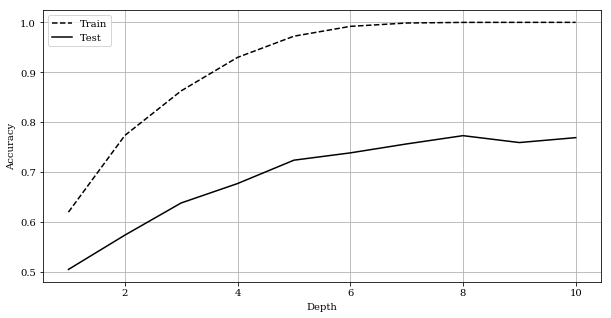

In [12]:
averages, averages_train = average_accuracies(X,y,10,10, False)

In [13]:
averages_train.to_csv('materials/avg_train_accuracy.csv')
averages_train

Run 1     Run 2     Run 3     Run 4     Run 5     Run 6     Run 7  \
Depth                                                                         
1      0.626371  0.605123  0.605615  0.619521  0.613062  0.621687  0.638463   
2      0.779241  0.765565  0.766838  0.790406  0.771983  0.772269  0.777629   
3      0.864836  0.854684  0.874478  0.860777  0.864863  0.869126  0.861542   
4      0.930043  0.935265  0.934063  0.927971  0.917962  0.928659  0.927292   
5      0.973262  0.975618  0.966900  0.966936  0.977119  0.975603  0.977394   
6      0.991886  0.992652  0.991165  0.987313  0.993366  0.994150  0.990539   
7      0.998529  0.998545  1.000000  0.998542  0.999222  0.997807  1.000000   
8      1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
9      1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
10     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

          Run 8     Run 9    Run 10  Average Accuracy  
Depth                                                  
1      0.599341  0.641371  0.629813          0.620037  
2      0.762206  0.779225  0.769415          0.773478  
3      0.861054  0.852504  0.864608          0.862847  
4      0.926224  0.938000  0.932749          0.929823  
5      0.973995  0.973939  0.961848          0.972261  
6      0.994133  0.993272  0.991111          0.991959  
7      0.998532  0.997789  0.997757          0.998672  
8      1.000000  1.000000  0.999248          0.999925  
9      1.000000  1.000000  1.000000          1.000000  
10     1.000000  1.000000  1.000000          1.000000

In [14]:
averages.to_csv('materials/avg_test_accuracy.csv')
averages

Run 1     Run 2     Run 3     Run 4     Run 5     Run 6     Run 7  \
Depth                                                                         
1      0.474516  0.515947  0.483378  0.542420  0.494444  0.526923  0.509672   
2      0.595479  0.551552  0.567926  0.574471  0.577868  0.558255  0.546289   
3      0.632051  0.651192  0.647368  0.632096  0.627688  0.630387  0.615452   
4      0.683693  0.678228  0.698740  0.656613  0.684930  0.647638  0.683941   
5      0.713270  0.710594  0.731354  0.700180  0.754858  0.739901  0.704971   
6      0.710706  0.752542  0.757962  0.736797  0.752587  0.741003  0.740868   
7      0.772492  0.747728  0.742735  0.778632  0.778048  0.789991  0.732096   
8      0.777755  0.772919  0.779465  0.780049  0.768106  0.746154  0.786032   
9      0.752722  0.758547  0.772312  0.778430  0.721233  0.789856  0.763090   
10     0.778160  0.789159  0.783446  0.740733  0.778902  0.768061  0.780049   

          Run 8     Run 9    Run 10  Average Accuracy  
Depth                                                  
1      0.508142  0.473369  0.524179          0.505299  
2      0.595434  0.593567  0.578610          0.573945  
3      0.641633  0.635830  0.670400          0.638410  
4      0.658052  0.684615  0.696131          0.677258  
5      0.711673  0.778767  0.694872          0.724044  
6      0.699888  0.748133  0.746019          0.738650  
7      0.752969  0.738462  0.732771          0.756592  
8      0.769051  0.768511  0.783581          0.773162  
9      0.758277  0.731084  0.768061          0.759361  
10     0.758120  0.773099  0.741880          0.769161

# Categories

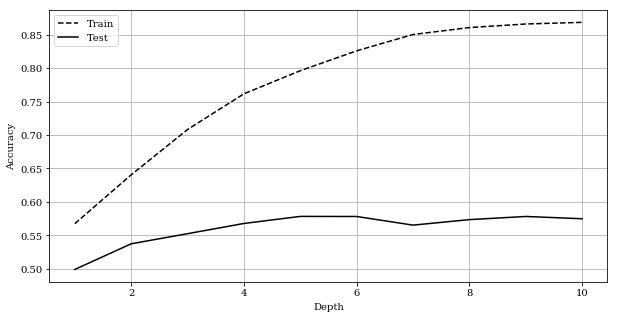

In [15]:
averages_cat, averages_train_cat = average_accuracies(X,y,10,10, True)

In [16]:
averages_train_cat.to_csv('materials/avg_train_accuracy_cat.csv')
averages_cat.to_csv('materials/avg_test_accuracy_cat.csv')

<br>

# Model

Categories in the entire set:
1    84
2    64
3    25
4    17
Name: label, dtype: int64 

Categories in the test set:
1    17
2    13
3     5
4     3
Name: label, dtype: int64 

Categories in the train set before ADASYN method:
1    67
2    51
3    20
4    14
Name: label, dtype: int64 

Categories in the train set after ADASYN method:
1    67
2    72
3    65
4    65
dtype: int64 

Accuracy with a depth of 4 and 100 trees:
0.6842105263157895 

Classification Report:
              precision    recall  f1-score   support

           1       0.71      0.88      0.79        17
           2       0.75      0.46      0.57        13
           3       0.50      0.60      0.55         5
           4       0.67      0.67      0.67         3

   micro avg       0.68      0.68      0.68        38
   macro avg       0.66      0.65      0.64        38
weighted avg       0.69      0.68      0.67        38
 

Confusion matrix:
[[15  2  0  0]
 [ 4  6  3  0]
 [ 1  0  3  1]
 [ 1  0  0  2]] 



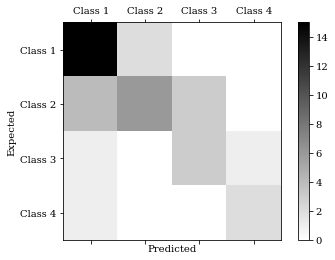



Feature importance in the model:
                                                            Definition  Importance
Feature                                                                           
PC_CA-avg_3y                  Current account balance - 3 year average    0.144399
UR-avg_3y                           Unemployment rate - 3 year average    0.134830
NIIP-pc_gdp          Net international investment position - annual...    0.093351
GD-pc_gdp            General government gross debt (EDP concept) co...    0.086133
LTU-pch_3y           Long-term unemployment rate % of active popula...    0.084748
YUR-pch_3y           Youth unemployment rate - % of active populati...    0.083585
FSL-pch              Total financial sector liabilities non-consoli...    0.078117
PSD-pc_gdp           Private sector debt consolidated - % of GDP - ...    0.074186
ULC-pch_3y                 Nominal unit labour cost - 3 years % change    0.045723
X_GS_share_M-pch_5y         GS Export market shares 

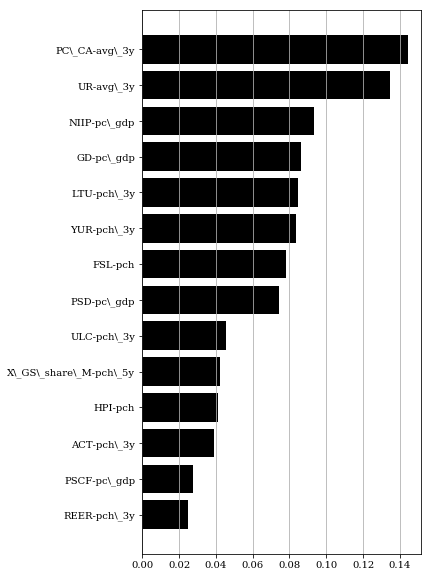

In [17]:
rf, train, test, tables = model(X,y, model_preproc, 4, 100, thresh=False)
for i in ['materials', 'model']: train.to_csv(f"./{i}/train.csv", index=False)
for i in ['materials', 'model']: test.to_csv(f"./{i}/test.csv", index=False)

In [18]:
tables[0].to_csv('./materials/feature_importance.csv')
tables[0]

Definition  \
Feature                                                                  
PC_CA-avg_3y                  Current account balance - 3 year average   
UR-avg_3y                           Unemployment rate - 3 year average   
NIIP-pc_gdp          Net international investment position - annual...   
GD-pc_gdp            General government gross debt (EDP concept) co...   
LTU-pch_3y           Long-term unemployment rate % of active popula...   
YUR-pch_3y           Youth unemployment rate - % of active populati...   
FSL-pch              Total financial sector liabilities non-consoli...   
PSD-pc_gdp           Private sector debt consolidated - % of GDP - ...   
ULC-pch_3y                 Nominal unit labour cost - 3 years % change   
X_GS_share_M-pch_5y         GS Export market shares - 5 years % change   
HPI-pch                House price index deflated - annual data - pch    
ACT-pch_3y           Activity rate - % of total population aged 15-...   
PSCF-pc_gdp          Private sector credit flow consolidated - % GD...   
REER-pch_3y          Real effective exchange rate (42 trading partn...   

                     Importance  
Feature                          
PC_CA-avg_3y           0.144399  
UR-avg_3y              0.134830  
NIIP-pc_gdp            0.093351  
GD-pc_gdp              0.086133  
LTU-pch_3y             0.084748  
YUR-pch_3y             0.083585  
FSL-pch                0.078117  
PSD-pc_gdp             0.074186  
ULC-pch_3y             0.045723  
X_GS_share_M-pch_5y    0.042268  
HPI-pch                0.041068  
ACT-pch_3y             0.039128  
PSCF-pc_gdp            0.027541  
REER-pch_3y            0.024921

In [19]:
tables[1].to_csv('./materials/classification_report.csv');
tables[1]

f1-score  precision    recall  support
1             0.789474   0.714286  0.882353     17.0
2             0.571429   0.750000  0.461538     13.0
3             0.545455   0.500000  0.600000      5.0
4             0.666667   0.666667  0.666667      3.0
micro avg     0.684211   0.684211  0.684211     38.0
macro avg     0.643256   0.657738  0.652640     38.0
weighted avg  0.673076   0.694549  0.684211     38.0

<br>

# Interesting

The only countries wrongly classified in the ```test``` were:


In [20]:
test[(test.label==2)&(test.pred!=2)]

PC_CA-avg_3y  REER-pch_3y  X_GS_share_M-pch_5y  FSL-pch  GD-pc_gdp  \
2013_ES          -0.6         -0.3               -11.22    -10.5       95.5   
2016_ES           1.5         -4.3                 2.69      1.0       99.0   
2014_DE           7.1         -0.4                -8.90      4.6       74.5   
2017_SE           3.7         -5.4                -4.36      6.8       40.8   
2016_NL           7.6         -2.2                -2.89      6.0       61.9   
2012_MT          -2.9         -7.6                12.18      6.1       67.7   
2017_ES           1.8         -2.5                 9.79      4.1       98.1   

         HPI-pch  NIIP-pc_gdp  ULC-pch_3y  ACT-pch_3y  LTU-pch_3y  YUR-pch_3y  \
2013_ES    96.24        -95.2        -4.1         0.8         5.7        14.0   
2016_ES   104.62        -85.3        -0.5        -0.1        -3.5       -11.1   
2014_DE    96.08         40.6         6.7         0.4        -0.6        -0.8   
2017_SE   112.54          4.4         3.8         1.0        -0.2        -5.1   
2016_NL   104.39         62.7        -0.6         0.3         0.0        -2.4   
2012_MT    95.50         19.6         8.7         4.5         0.1        -0.7   
2017_ES   109.35        -83.8         0.0        -0.3        -5.2       -14.6   

         PSCF-pc_gdp  PSD-pc_gdp  UR-avg_3y  label  pred  
2013_ES        -10.3       177.2       24.1      2     3  
2016_ES         -1.1       147.1       22.1      2     3  
2014_DE          0.1        98.6        5.2      2     1  
2017_SE         13.1       194.4        7.0      2     1  
2016_NL          5.6       262.1        6.8      2     1  
2012_MT         -0.7       153.2        6.5      2     1  
2017_ES          0.4       139.3       19.6      2     3

<br>